In [1]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.6 MB/s eta 0:00:00


# 1 - Preparar el dataset

In [2]:
# Importar librerías

import os, json, re, html, unicodedata, pathlib, warnings, itertools, pprint, joblib
import pandas as pd
import numpy as np
#from emoji import demojize                 # ←  convierte 🙂 → :slightly_smiling_face:
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Función de limpieza mejorada  (conserva señales afectivas)
URL      = re.compile(r"https?://\S+|www\.\S+")
MENTION  = re.compile(r"@\w+")
NUMBER   = re.compile(r"\b\d[\d,.]*\b")
WHITES   = re.compile(r"\s+")

def clean_text(text: str) -> str:
    """Mantiene emojis (demojizados), ¡!¿? y reduce ruido."""
    text = html.unescape(text)
    text = URL.sub(" URL ", text)
    text = MENTION.sub(" MENTION ", text)
    text = NUMBER.sub(" NUM ", text)
    #text = demojize(text, delimiters=(" EMOJI_", "_EMOJI "))
    text = text.lower()
    text = unicodedata.normalize("NFKC", text)
    # eliminamos TODO salvo letras, signos de exclamación/interrogación, dos puntos y los tokens creados
    text = re.sub(r"[^a-záéíóúüñàèìòùü¿¡:_\s]", " ", text)
    text = WHITES.sub(" ", text).strip()
    return text

In [5]:
# Loader genérico para un sub-corpus (Anxiety, Depression, TCA…)

def build_df_from_folder(json_dir: str, csv_path: str) -> pd.DataFrame:
    """Devuelve DataFrame user-level con text_clean + label (0/1)."""
    labels_df = (pd.read_csv(csv_path, sep="\t")[["nick", "bs"]]
                 .rename(columns={"nick": "user", "bs": "label"})
                 .dropna())

    rows = []
    for file in os.listdir(json_dir):
        if file.endswith(".json") and file.startswith("subject"):
            user_id = file[:-5]                          # sin '.json'
            label_row = labels_df[labels_df["user"] == user_id]
            if label_row.empty:
                continue
            label = int(label_row["label"].values[0])

            with open(os.path.join(json_dir, file), encoding="utf-8") as f:
                msgs = json.load(f)

            for m in msgs:
                if "message" in m and isinstance(m["message"], str):
                    rows.append({"user": user_id,
                                 "message": m["message"],
                                 "label": label})

    df_msgs = pd.DataFrame(rows)
    if df_msgs.empty:
        raise ValueError(f"¡Sin datos en {json_dir}!")
    # Limpieza
    df_msgs["message_clean"] = df_msgs["message"].apply(clean_text)

    # Concatenamos mensajes por usuario
    df_user = (df_msgs
               .groupby(["user", "label"])["message_clean"]
               .agg(lambda col: " ".join(col))
               .reset_index())
    return df_user

In [6]:
# Unir todos los sub-corpora

SUBSETS = {
    "Anxiety": {
        "json_dir": "/content/drive/MyDrive/Proyecto FINAL/corpusMentalRiskES/processed/Anxiety/data",
        "csv_path": "/content/drive/MyDrive/Proyecto FINAL/corpusMentalRiskES/processed/Anxiety/gold/gold_label.csv",
    },
    # descomenta / añade si tienes Depresión y TCA
    # "Depression": { … },
    # "TCA":        { … },
}

df_all_processed = pd.concat([build_df_from_folder(v["json_dir"], v["csv_path"])
                    for v in SUBSETS.values()],
                   ignore_index=True)

print("Distribución final de etiquetas:")
print(df_all_processed["label"].value_counts())

Distribución final de etiquetas:
label
1    443
0     57
Name: count, dtype: int64


In [7]:
# verificar el contenido del df_all_processed

print(df_all_processed.head())
print(df_all_processed.info())
print(df_all_processed.describe())


         user  label                                      message_clean
0    subject1      1  buenos días a tod mention no sé si esta será l...
1   subject10      0  ola soi nuebo como estn a ustds los entimdm ke...
2  subject100      1  de donde son yo de perú supongo q tb sigue en ...
3  subject101      1  es lo que necesitas aaah pues perdón por no ha...
4  subject102      1  ya perdí una xd siete seguidas no está mal el ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user           500 non-null    object
 1   label          500 non-null    int64 
 2   message_clean  500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB
None
           label
count  500.00000
mean     0.88600
std      0.31813
min      0.00000
25%      1.00000
50%      1.00000
75%      1.00000
max      1.00000


In [8]:
# Guardamos a disco

df_all_processed.to_csv("MentalRiskES_userlevel_clean_processed.csv", index=False)
print("\nCSV consolidado → MentalRiskES_userlevel_clean_processed.csv")


CSV consolidado → MentalRiskES_userlevel_clean_processed.csv


# 2 – Vectorización TF-IDF + SVM con búsqueda de hiperparámetros y validación macro-F1

In [9]:
# Importar librerías
import pandas as pd, numpy as np, pprint, joblib, warnings, itertools
from pathlib import Path
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [10]:
# Cargar CSV consolidado
CSV_PATH = "MentalRiskES_userlevel_clean_processed.csv"    # ← MODIFICA si lo guardaste con otro nombre
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape, "| Etiquetas:", df['label'].value_counts().to_dict())


Shape: (500, 3) | Etiquetas: {1: 443, 0: 57}


In [11]:
# Split estratificado 70/15/15  (train / val / test)
X_temp, X_test, y_temp, y_test = train_test_split(
    df["message_clean"], df["label"],
    test_size=0.15, random_state=42, stratify=df["label"])

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765, random_state=42, stratify=y_temp)  # 0.1765*0.85 ≈ 15 %

print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

Train=349, Val=76, Test=75


In [12]:
# Vectorizadores TF-IDF (palabra + carácter)
word_vect = TfidfVectorizer(
    analyzer="word", ngram_range=(1,2),   # ajustable vía grid
    min_df=2,  sublinear_tf=True, strip_accents="unicode",
    max_features=50_000)

char_vect = TfidfVectorizer(
    analyzer="char_wb", ngram_range=(3,5),
    min_df=2,  sublinear_tf=True, strip_accents="unicode",
    max_features=100_000)

vect = ColumnTransformer(
    transformers=[("word", word_vect, "text"),
                  ("char", char_vect, "text")],
    remainder="drop", verbose=False)

In [13]:
# Pipeline Imbalanced-Learn  (oversampling opcional)
svm = LinearSVC(class_weight="balanced")
pipe = ImbPipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42, sampling_strategy="auto")),
    ("vect", vect),
    ("clf", svm),
])

# Necesitamos DataFrame para ColumnTransformer
train_df = pd.DataFrame({"text": X_train, "label": y_train})
val_df   = pd.DataFrame({"text": X_val,   "label": y_val})

In [14]:
!pip install tqdm tqdm_joblib

In [15]:
# GridSearchCV – macro-F1 (equilibra ambas clases)


from sklearn.model_selection import ParameterGrid
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

param_grid = {
    "vect__word__ngram_range": [(1,1), (1,2)],
    "vect__word__min_df": [2,5],
    "vect__char__min_df": [2,5],
    "clf__C": [0.25, 0.5, 1, 2, 4],
    "oversample": [RandomOverSampler(random_state=42), "passthrough"],
}
macro_f1 = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_candidates = len(list(ParameterGrid(param_grid)))
total_fits   = n_candidates * cv.get_n_splits()

print(f"Total de configuraciones * folds: {total_fits}")

with tqdm_joblib(tqdm(desc="GridSearch", total=total_fits)) as _:
    grid = GridSearchCV(
        pipe,
        param_grid=param_grid,
        scoring=macro_f1,
        cv=cv,
        n_jobs=-1,
        verbose=0,     # mantenemos limpio el output
        refit=True,
    )
    grid.fit(train_df, y_train)
print("\n===== Mejores hiperparámetros =====")
pprint.pprint(grid.best_params_)
print(f"Macro-F1 (CV interno): {grid.best_score_:.4f}")

Total de configuraciones * folds: 400


GridSearch:   0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]


===== Mejores hiperparámetros =====
{'clf__C': 0.25,
 'oversample': 'passthrough',
 'vect__char__min_df': 5,
 'vect__word__min_df': 5,
 'vect__word__ngram_range': (1, 1)}
Macro-F1 (CV interno): 0.6227



===== VALIDACIÓN (15 %) =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.8816    1.0000    0.9371        67

    accuracy                         0.8816        76
   macro avg     0.4408    0.5000    0.4685        76
weighted avg     0.7772    0.8816    0.8261        76



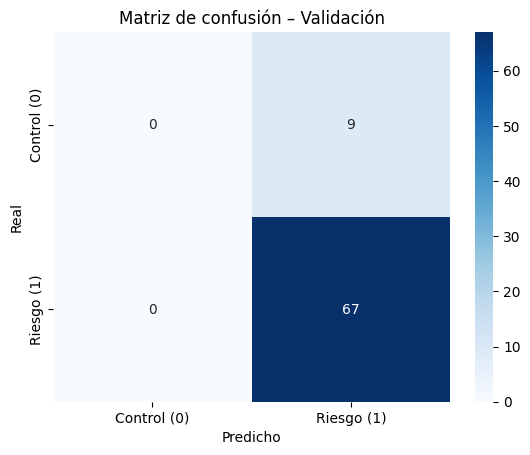

In [16]:
# Evaluación en VALIDACIÓN (15 %)

y_val_pred = grid.predict(val_df)
print("\n===== VALIDACIÓN (15 %) =====")
print(classification_report(y_val, y_val_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Control (0)", "Riesgo (1)"],
            yticklabels=["Control (0)", "Riesgo (1)"])
plt.title("Matriz de confusión – Validación")
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.show()

In [17]:
# Serializar el mejor modelo
MODEL_PATH = "svm_tfidf_best.joblib"   # ← nombre a tu gusto
joblib.dump(grid.best_estimator_, MODEL_PATH)
print("Modelo guardado en", MODEL_PATH)



Modelo guardado en svm_tfidf_best.joblib


In [18]:
# Evaluación en TEST final

test_df = pd.DataFrame({"text": X_test})
y_test_pred = grid.predict(test_df)
print("\n===== TEST final (15 %) =====")
print(classification_report(y_test, y_test_pred, digits=4))


===== TEST final (15 %) =====
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         9
           1     0.8767    0.9697    0.9209        66

    accuracy                         0.8533        75
   macro avg     0.4384    0.4848    0.4604        75
weighted avg     0.7715    0.8533    0.8104        75



# 3  – Re-grid + búsqueda de umbral óptimo

In [19]:
# Importar librerias adicionales
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV   # para probas si quieres
from sklearn.preprocessing import FunctionTransformer   # para convertir a denso
from sklearn.pipeline import Pipeline
import numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [20]:
# Preparamos un SVM calibrado (para poder mover el umbral)
# -> CalibratedClassifierCV envuelve LinearSVC y devuelve probas

from sklearn.svm import LinearSVC
base_svm = LinearSVC(class_weight="balanced")

cal_svm = CalibratedClassifierCV(
    estimator=base_svm,
    method="sigmoid",           # Platt scaling
    cv=3,                       # calibración interna
)

pipe_cal = ImbPipeline(steps=[
    ("oversample", RandomOverSampler(random_state=42)),  # forzamos ON
    ("vect", vect),                                      # mismo ColumnTransformer
    ("clf", cal_svm),
])



In [21]:
# Grid reducido pero con C alto y min_df bajo
param_grid2 = {
    "vect__word__ngram_range": [(1,1), (1,2)],
    "vect__word__min_df": [1,2],
    "vect__char__min_df": [1,2],
    "clf__estimator__C": [1, 2, 4, 8, 16, 32],
}

grid2 = GridSearchCV(
    estimator=pipe_cal,
    param_grid=param_grid2,
    scoring=macro_f1,     # ya definido antes
    cv=cv, n_jobs=-1, verbose=3, refit=True)

grid2.fit(train_df, y_train)

print("\n»»» Mejores hiperparámetros v2")
pprint.pprint(grid2.best_params_)
print(f"Macro-F1 (CV interno): {grid2.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

»»» Mejores hiperparámetros v2
{'clf__estimator__C': 1,
 'vect__char__min_df': 1,
 'vect__word__min_df': 1,
 'vect__word__ngram_range': (1, 1)}
Macro-F1 (CV interno): 0.4704



Umbral óptimo en validación: τ = 0.954  |  macro-F1 = 0.9624


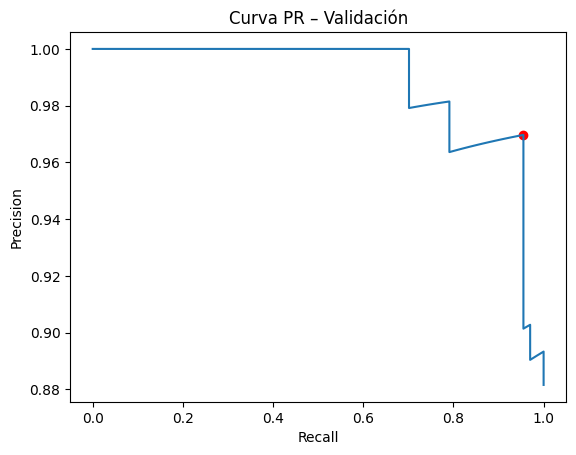

In [22]:
# Optimizar UMBRAL en validación
val_df_onlytext = pd.DataFrame({"text": X_val})
probas_val = grid2.predict_proba(val_df_onlytext)[:,1]   # p(clase1)
prec, rec, thr = precision_recall_curve(y_val, probas_val)
f1_scores = 2*prec*rec / (prec+rec + 1e-9)
best_idx   = np.argmax(f1_scores)
best_thr   = thr[best_idx]
best_f1    = f1_scores[best_idx]

print(f"\nUmbral óptimo en validación: τ = {best_thr:.3f}  |  macro-F1 = {best_f1:.4f}")

# Curva PR opcional
plt.plot(rec, prec); plt.scatter(rec[best_idx], prec[best_idx], c="red")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Curva PR – Validación")
plt.show()


===== VALIDACIÓN con τ óptimo =====
              precision    recall  f1-score   support

           0     0.7000    0.7778    0.7368         9
           1     0.9697    0.9552    0.9624        67

    accuracy                         0.9342        76
   macro avg     0.8348    0.8665    0.8496        76
weighted avg     0.9378    0.9342    0.9357        76



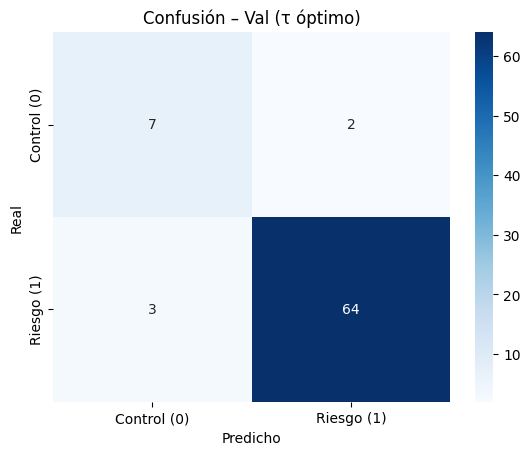

In [23]:
# Métricas con el nuevo umbral
val_pred_opt = (probas_val >= best_thr).astype(int)
print("\n===== VALIDACIÓN con τ óptimo =====")
print(classification_report(y_val, val_pred_opt, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_val, val_pred_opt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Control (0)", "Riesgo (1)"],
            yticklabels=["Control (0)", "Riesgo (1)"])
plt.title("Confusión – Val (τ óptimo)")
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.show()

In [24]:
# Guardar modelo + umbral
joblib.dump({"model": grid2.best_estimator_,
             "threshold": best_thr},
            "svm_tfidf_thresholded.joblib")
print("Modelo + τ guardados en svm_tfidf_thresholded.joblib")

Modelo + τ guardados en svm_tfidf_thresholded.joblib


# 4 – Evaluar en TEST usando el modelo + τ salvados

In [25]:
# Carga del modelo entrenado con calibración y su umbral óptimo
import joblib, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

bundle = joblib.load("svm_tfidf_thresholded.joblib")
model       = bundle["model"]
best_thr    = bundle["threshold"]

print(f"Umbral cargado: τ = {best_thr:.3f}")


Umbral cargado: τ = 0.954


In [26]:
# Preparar X_test
test_df = pd.DataFrame({"text": X_test})          # X_test viene del Bloque 2
probas_test = model.predict_proba(test_df)[:,1]   # p(clase 1)

y_test_pred_opt = (probas_test >= best_thr).astype(int)


===== TEST FINAL =====
              precision    recall  f1-score   support

           0     0.3571    0.5556    0.4348         9
           1     0.9344    0.8636    0.8976        66

    accuracy                         0.8267        75
   macro avg     0.6458    0.7096    0.6662        75
weighted avg     0.8652    0.8267    0.8421        75



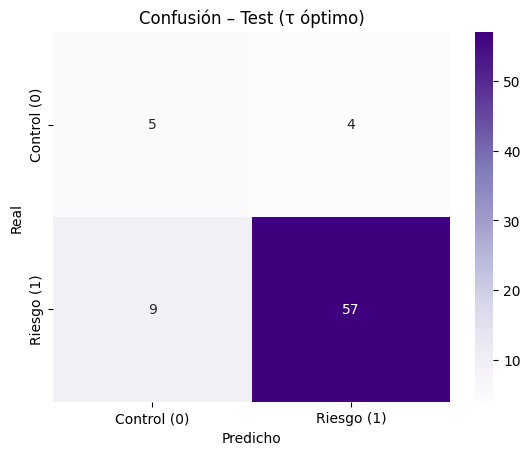

In [27]:
# ÍMétricas y matriz de confusión
print("\n===== TEST FINAL =====")
print(classification_report(y_test, y_test_pred_opt, digits=4))

cm = confusion_matrix(y_test, y_test_pred_opt)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Control (0)", "Riesgo (1)"],
            yticklabels=["Control (0)", "Riesgo (1)"])
plt.title("Confusión – Test (τ óptimo)")
plt.xlabel("Predicho"); plt.ylabel("Real"); plt.show()

# 5 -  Evaluaciones manuales (Validación cualitativa del modelo)

In [28]:
import pandas as pd
import joblib
import numpy as np

In [29]:
# Cargar el modelo y umbral
bundle = joblib.load("svm_tfidf_thresholded.joblib")
model = bundle["model"]
tau   = bundle["threshold"]

In [35]:
# Textos de ejemplo
textos_prueba = [
    "No puedo dormir, mi corazón late muy rápido por las noches.",
    "Me sudan las manos cuando estoy solo.",
    "A veces me falta el aire sin razón aparente.",
    "Siento que algo malo va a pasar aunque no hay motivo.",
    "Estoy harto, no sé cómo parar estos pensamientos.",
    "Hoy me desperté feliz, con muchas ganas de salir.",
    "Todo está en calma, me siento estable emocionalmente.",
    "Amo mi trabajo y estoy disfrutando la vida.",
    "Lo tengo ansiedad, solo algo de cansancio normal.",
    "La terapia me ha ayudado mucho, ya no tengo miedo."
]



# Predecir con el pipeline
def evaluar_textos_modelo_calibrado(textos):
    df = pd.DataFrame({"text": textos})
    # Usamos predict_proba directamente porque el modelo está calibrado
    proba_riesgo = model.predict_proba(df)[:, 1]
    etiquetas = np.where(proba_riesgo >= tau, "Sufre ansiedad", "Control (no sufre)")

    resultados = pd.DataFrame({
        "Texto": textos,
        "Predicción": etiquetas,
        "Prob. Ansiedad": np.round(proba_riesgo, 4)
    }).sort_values(by="Prob. Ansiedad", ascending=False)

    return resultados

df_resultados_svm = evaluar_textos_modelo_calibrado(textos_prueba)
df_resultados_svm

,Texto,Predicción,Prob. Ansiedad
8,"Lo tengo ansiedad, solo algo de cansancio normal.",Sufre ansiedad,0.9851
9,"La terapia me ha ayudado mucho, ya no tengo mi...",Sufre ansiedad,0.9762
1,Me sudan las manos cuando estoy solo.,Control (no sufre),0.9507
4,"Estoy harto, no sé cómo parar estos pensamientos.",Control (no sufre),0.9363
2,A veces me falta el aire sin razón aparente.,Control (no sufre),0.9306
7,Amo mi trabajo y estoy disfrutando la vida.,Control (no sufre),0.9195
0,"No puedo dormir, mi corazón late muy rápido po...",Control (no sufre),0.9097
6,"Todo está en calma, me siento estable emociona...",Control (no sufre),0.8799
5,"Hoy me desperté feliz, con muchas ganas de salir.",Control (no sufre),0.8688
3,Siento que algo malo va a pasar aunque no hay ...,Control (no sufre),0.7812
